In [1]:
import os
import sys
import time
import json
import datetime
import random
import tarfile

import numpy as np
import pandas as pd
from PIL import Image

PATH = "../tubs/tub5"

In [2]:
#make sure tensorflow version is the same as one installed on donkeycar (1.8.0)
import tensorflow as tf
print(tf.__version__)

1.8.0


In [3]:
#check if GPU is present (/device:GPU:0)
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

['/device:GPU:0']

In [10]:
json_files = [file for file in os.listdir(PATH) if file.endswith('json') ]

In [11]:
len(json_files)

38575

In [12]:
meta_json = pd.read_json(f'{PATH}/{json_files[0]}')

In [13]:
meta_json

,inputs,types
0,cam/image_array,image_array
1,user/angle,float
2,user/throttle,float
3,user/mode,str
4,timestamp,str


In [14]:
with open(f'{PATH}/{json_files[1]}', 'r') as f:
    data = json.load(f)

In [15]:
data["user/throttle"]

0.08

In [21]:
df = pd.DataFrame(data, index = [0])

In [22]:
df

,cam/image_array,user/throttle,user/angle,timestamp,user/mode
0,0_cam-image_array_.jpg,0.08,0.01,None,user


In [43]:
df["cam/image_array"][0]

'0_cam-image_array_.jpg'

In [16]:
def json_to_df(PATH, json_files, max_items=None):
    df = pd.DataFrame()
    for i, j in enumerate(json_files[1:max_items]):
        with open(f'{PATH}/{j}') as f:
            data = json.load(f)

            userThrottle = data["user/throttle"]
            userAngle = data["user/angle"]
            camImage_array = data["cam/image_array"]
            index = int(camImage_array[:-21])
            df_row = pd.DataFrame([[userThrottle, userAngle, camImage_array]], index = [index], columns = ["user/throttle", "user/angle", "cam/image_array"])

            df = df.append(df_row)
    df = df.sort_index()
    return df

In [17]:
len(json_files[1:None])

38574

In [30]:
df = json_to_df(PATH, json_files, max_items=None)

In [31]:
df.to_feather('tmp/df')

In [4]:
df = pd.read_feather('tmp/df')

C:\Users\Jason\Anaconda3\envs\tf-gpu\lib\site-packages\pandas\io\feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [5]:
df.head(20)

,user/throttle,user/angle,cam/image_array
0,0.08,0.01,0_cam-image_array_.jpg
1,0.12,-0.03,1_cam-image_array_.jpg
2,0.12,-0.03,2_cam-image_array_.jpg
3,0.14,-0.06,3_cam-image_array_.jpg
4,0.14,-0.06,4_cam-image_array_.jpg
5,0.17,-0.12,5_cam-image_array_.jpg
6,0.17,-0.12,6_cam-image_array_.jpg
7,0.17,-0.14,7_cam-image_array_.jpg
8,0.21,-0.17,8_cam-image_array_.jpg
9,0.21,-0.17,9_cam-image_array_.jpg


In [6]:
def get_prev_img_names(img_name, quantity):
    img_names = []
    last_name = img_name
    for i in range(0, quantity):
        index = int(img_name[:-21])-i
        if index < 0:
            name = last_name
        else:
            name = str(index)+"_cam-image_array_.jpg"
        
        img_names.append(name)
        last_name = name
    img_names.reverse()
    return img_names

In [70]:
get_prev_img_names("20_cam-image_array_.jpg", 3)

['18_cam-image_array_.jpg',
 '19_cam-image_array_.jpg',
 '20_cam-image_array_.jpg']

In [7]:
def to_bin(a):
    arr = np.zeros(15)
    a = a + 1
    b = round(a/(2/14))
    arr[int(b)] = 1
    return arr

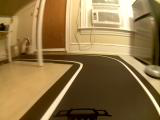

In [8]:
img_name = df['cam/image_array'][100]
img = Image.open(f'{PATH}/{img_name}')
img

In [10]:
bs = 128 # or 128/3
train_frac = 0.8
X_keys = ['cam/image_array']
y_keys = ['user/angle', 'user/throttle']
PATH
new_model_path = 'models/pilot_jn_cnnrnn'

In [83]:
def read_record(record_dict, path = PATH):
    data = {}
    for key, val in record_dict.items():
        if key == 'cam/image_array':
            images = get_prev_img_names(val, 10)
            data[key] = []
            for i, name in enumerate(images):
                img = Image.open(f'{PATH}/{name}')
                data[key].append(np.array(img))
            data[key] = np.array(data[key])
        else:
            data[key] = val
        
        
    return data

In [84]:
def get_record_gen(record_transform=None, shuffle=True, df=None):
    while True:
        for _ in df.iterrows():
            if shuffle:
                record_dict = df.sample(n=1).to_dict(orient='record')[0]
            
            record_dict = read_record(record_dict)
            
            if record_transform:
                record_dict = record_transform(record_dict)
            
            yield record_dict

In [85]:
def get_batch_gen(keys=None, batch_size=128, record_transform=None, shuffle=True, df=None):
    
    record_gen = get_record_gen(record_transform=record_transform, shuffle=shuffle, df=df)
    
    while True:
        record_list = [next(record_gen) for _ in range(batch_size)]
        
        batch_arrays = {}
        for i, k in enumerate(keys):
            arr = np.array([r[k] for r in record_list])
            batch_arrays[k] = arr
        yield batch_arrays

In [86]:
def get_train_gen(X_keys, Y_keys, batch_size=128, record_transform=None, df=None): #
    batch_gen = get_batch_gen(X_keys + Y_keys, batch_size=batch_size,
                                  record_transform=record_transform, df=df)
    while True:
        batch = next(batch_gen)
        X = [batch[k] for k in X_keys]
        Y = [batch[k] for k in Y_keys] 
        yield X, Y

In [87]:
def get_train_val_gen(df, X_keys, Y_keys, batch_size = 128, train_frac=0.8, #
                      train_record_transform=None, val_record_transform=None): #
    train_df = df.sample(frac=train_frac, random_state=200) #
    val_df = df.drop(train_df.index) #
    
    train_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                             record_transform=train_record_transform, df=train_df)
    val_gen = get_train_gen(X_keys=X_keys, Y_keys=Y_keys, batch_size=batch_size,
                           record_transform=val_record_transform, df=val_df)
    return train_gen, val_gen
    

In [88]:
def record_transform(record):
    record['user/angle'] = to_bin(record['user/angle'])
    return record

In [96]:
train_gen, val_gen = get_train_val_gen(df, X_keys, y_keys,
                                               train_record_transform=record_transform, #
                                               val_record_transform=record_transform, #
                                               batch_size=bs, #
                                               train_frac=train_frac) #

In [90]:
test = next(train_gen)

In [93]:
test[0][0].shape

(128, 10, 120, 160, 3)

In [94]:
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.models import Model, load_model, Sequential
from tensorflow.python.keras.layers import Convolution2D, LSTM, TimeDistributed, GRU, RNN, MaxPooling2D
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Cropping2D, Lambda
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
cnn = Sequ

In [128]:
#CNN
cnn = Sequential()
cnn.add(Convolution2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 160, 3)))
cnn.add(Convolution2D(32, (5, 5), strides=(2, 2), activation='relu'))
cnn.add(Convolution2D(64, (5, 5), strides=(2, 2), activation='relu'))
cnn.add(Convolution2D(64, (3, 3), strides=(2, 2), activation='relu'))
cnn.add(Convolution2D(64, (3, 3), strides=(1, 1), activation='relu'))
cnn.add(Dense(100, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(50, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Flatten(name='flattened'))

#GRU 
img_in3D = Input(shape=(10, 120, 160, 3), name='img_in')
x = img_in3D
x = TimeDistributed(cnn)(x) # which dimension is used for time step? first dim in shape
x = GRU(150)(x)
x = Dropout(0.2)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.2)(x)
angle_out = Dense(15, activation='softmax', name='angle_out')(x)
throttle_out = Dense(1, activation='relu', name='throttle_out')(x) #Does relu really make sense here?


model = Model(inputs=[img_in3D], outputs=[angle_out, throttle_out])
model.compile(optimizer='rmsprop', 
              loss={'angle_out': 'categorical_crossentropy',
                   'throttle_out': 'mean_absolute_error'}, #should I use a different loss function because of gru?
              loss_weights={'angle_out': 0.9, 'throttle_out': 0.01}) # should throttle weight be adjusted?

In [129]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             (None, 10, 120, 160, 0                                            
__________________________________________________________________________________________________
time_distributed_5 (TimeDistrib (None, 10, 900)      157726      img_in[0][0]                     
__________________________________________________________________________________________________
gru_5 (GRU)                     (None, 150)          472950      time_distributed_5[0][0]         
__________________________________________________________________________________________________
dropout_19 (Dropout)            (None, 150)          0           gru_5[0][0]                      
__________________________________________________________________________________________________
dense_15 (

In [99]:
def train(train_gen, val_gen, saved_model_path, epochs=100, steps=100, train_split=0.8,
         verbose=1, min_delta=0.0005, patience=5, use_early_stop=True):
    
#     checkpoint to save model
    save_best = ModelCheckpoint(saved_model_path, monitor='val_loss', verbose=verbose, save_best_only=True, mode='min')
    
    #stop training if stop improving
    early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=verbose, mode='auto')
    
    callbacks_list = [save_best]
    
    if use_early_stop:
        callbacks_list.append(early_stop)
        
    hist = model.fit_generator(train_gen, steps_per_epoch=steps, epochs=epochs, verbose=1, validation_data=val_gen,
                                callbacks=callbacks_list, validation_steps=steps * (1.0 - train_frac)//train_frac)
    return hist

In [100]:
total_records = len(df)
total_train = int(total_records * train_frac)
total_val = total_records - total_train
steps_per_epoch = total_train // bs
steps_per_epoch

241

In [101]:
train(train_gen, val_gen, saved_model_path=new_model_path, steps=steps_per_epoch, train_split=0.8)

Epoch 1/100
240/241 [============================>.] - ETA: 1s - loss: 2.3519 - angle_out_loss: 2.6103 - throttle_out_loss: 0.2569
Epoch 00001: val_loss improved from inf to 2.25768, saving model to models/pilot_jn_cnnrnn
241/241 [==============================] - 359s 1s/step - loss: 2.3515 - angle_out_loss: 2.6100 - throttle_out_loss: 0.2568 - val_loss: 2.2577 - val_angle_out_loss: 2.5075 - val_throttle_out_loss: 0.0937
Epoch 2/100
240/241 [============================>.] - ETA: 1s - loss: 2.0895 - angle_out_loss: 2.3194 - throttle_out_loss: 0.1986
Epoch 00002: val_loss improved from 2.25768 to 1.91327, saving model to models/pilot_jn_cnnrnn
241/241 [==============================] - 340s 1s/step - loss: 2.0887 - angle_out_loss: 2.3185 - throttle_out_loss: 0.1983 - val_loss: 1.9133 - val_angle_out_loss: 2.1247 - val_throttle_out_loss: 0.1028
Epoch 3/100
240/241 [============================>.] - ETA: 1s - loss: 1.9473 - angle_out_loss: 2.1629 - throttle_out_loss: 0.0740
Epoch 00003: 

In [ ]:
"""
GRU with rmsprop optimizer
record
241/241 [==============================] - 137s 570ms/step - loss: 1.6156 - angle_out_loss: 1.7943 
- throttle_out_loss: 0.0702 - val_loss: 2.1860 - val_angle_out_loss: 2.4283 - val_throttle_out_loss: 0.0526
Epoch 00010: early stopping

GRU with 50 units
"""

In [104]:
#check against original
def unbin(arr):
    index = np.argmax(arr)
    return index/14*2-1
#     return index

In [105]:
unbin([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

0.0

In [111]:
def run(img_arr):
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    angle_binned, throttle = model.predict(img_arr)
    angle_unbinned = unbin(angle_binned[0])
    return angle_unbinned, throttle[0][0]

In [121]:
frame_idx = 200 #500 - 600

In [122]:
img_name = df['cam/image_array'][frame_idx]
images = get_prev_img_names(img_name, 10)
val = []
for i, name in enumerate(images):
    img = Image.open(f'{PATH}/{img_name}')
    val.append(np.array(img))
val = np.array(val)

In [123]:
val.shape

(10, 120, 160, 3)

In [124]:
#prediction
run(val)

(0.0, 0.32848734)

In [125]:
#compare to actual data
df['user/angle'][frame_idx], df['user/throttle'][frame_idx]

(-0.45, 0.29)

In [126]:
df['user/angle'][frame_idx-1], df['user/throttle'][frame_idx-1]

(-0.53, 0.33)

In [127]:
df['user/angle'][frame_idx-2], df['user/throttle'][frame_idx-2]

(-0.53, 0.33)